# **IMPORT LIBRARY**

In [1]:
# Import Library
import pandas as pd
## Preprocessing text
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
## Pelabelan
from nltk.corpus import opinion_lexicon
## Eksploarsi Label
from wordcloud import WordCloud
import matplotlib.pyplot as plt
## Splitting Data dan Ekstraksi Fitur
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
## Modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
### 3 skema
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical

# **LOAD DATASET**

In [2]:
# Load file CSV hasil scraping
url = "https://raw.githubusercontent.com/heriswaya/Sentiment-Analysis-Dicoding/main/ulasan_alibaba.csv"

# Load data ke DataFrame
app_reviews_df = pd.read_csv(url)

# Tampilkan informasi awal
print("Jumlah ulasan:", app_reviews_df.shape[0])
app_reviews_df.head()

Jumlah ulasan: 99000


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,27bf1c05-2d55-434b-8008-790a160016cd,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The app is great. I run a pretty good sized co...,5,5262,8.82.0,2025-03-15 18:38:47,NaN,NaN,8.82.0
1,69f9cd05-17e7-4459-92dd-b915fe959e0f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The app doesn't work properly. Firstly it tell...,2,1985,8.77.0,2025-01-25 21:37:16,We are sorry for your experience. If you have ...,2025-02-06 02:20:34,8.77.0
2,1d6cb16d-c070-4db3-8dc9-8bb7ba86cb37,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The apps functionality seriously sucks.... Sea...,1,3539,8.71.1,2024-12-02 13:06:25,We are sorry for your experience. If you have ...,2024-12-03 01:23:10,8.71.1
3,c83c1e64-6aa3-42e8-9a56-0385a297b87b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Buyer beware! They have tons of listings that ...,1,2871,7.26.2,2021-01-25 04:11:00,NaN,NaN,7.26.2
4,ef5a3285-4849-4fe8-8855-e8315f07ebd9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"The items are great, but when I click on one o...",2,15608,8.28.0,2023-10-23 05:10:01,"Hi, we are sorry to hear that. Do share additi...",2023-11-10 11:05:44,8.28.0


In [3]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99000 entries, 0 to 98999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              99000 non-null  object
 1   userName              99000 non-null  object
 2   userImage             99000 non-null  object
 3   content               99000 non-null  object
 4   score                 99000 non-null  int64 
 5   thumbsUpCount         99000 non-null  int64 
 6   reviewCreatedVersion  75808 non-null  object
 7   at                    99000 non-null  object
 8   replyContent          10441 non-null  object
 9   repliedAt             10441 non-null  object
 10  appVersion            75808 non-null  object
dtypes: int64(2), object(9)
memory usage: 8.3+ MB


In [4]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = app_reviews_df.dropna()

# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [5]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6961 entries, 1 to 98948
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              6961 non-null   object
 1   userName              6961 non-null   object
 2   userImage             6961 non-null   object
 3   content               6961 non-null   object
 4   score                 6961 non-null   int64 
 5   thumbsUpCount         6961 non-null   int64 
 6   reviewCreatedVersion  6961 non-null   object
 7   at                    6961 non-null   object
 8   replyContent          6961 non-null   object
 9   repliedAt             6961 non-null   object
 10  appVersion            6961 non-null   object
dtypes: int64(2), object(9)
memory usage: 652.6+ KB


# **PREPROCESSING TEXT**

In [6]:
# Download data NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# Inisialisasi stemmer dan stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [8]:
# Function: Membersihkan teks
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # remove mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # remove hashtags
    text = re.sub(r'RT[\s]+', '', text)        # remove RT
    text = re.sub(r"http\S+", '', text)        # remove links
    text = re.sub(r'[0-9]+', '', text)         # remove numbers
    text = re.sub(r'[^\x00-\x7F]+', ' ', text) # remove non-ASCII (emoji, simbol asing)
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    return text

# Funtion: Mengubah semua karakter dalam teks menjadi huruf kecil
def casefoldingText(text):
    text = text.lower()
    return text

# Function: Tokenizing
def tokenizingText(text):
    return word_tokenize(text)

# Function: Stopword removal
def filteringText(tokens):
    return [word for word in tokens if word not in stop_words]

# Function: Stemming
def stemmingText(tokens):
    return [stemmer.stem(word) for word in tokens]

# Function: Ubah token jadi kalimat lagi
def toSentence(tokens):
    return ' '.join(tokens)

# Function: Ubah slangwords ke kata aslinya
slangwords = {
    # Common slang
    "u": "you",
    "ur": "your",
    "r": "are",
    "ya": "you",
    "thx": "thanks",
    "pls": "please",
    "im": "i am",
    "idk": "i do not know",
    "lol": "laugh out loud",
    "btw": "by the way",
    "omg": "oh my god",
    "b4": "before",
    "cuz": "because",
    "wanna": "want to",
    "gonna": "going to",
    "gotta": "got to",
    "aint": "am not",
    "luv": "love",

    # Extended list
    "2day": "today",
    "2moro": "tomorrow",
    "2nite": "tonight",
    "4ever": "forever",
    "4u": "for you",
    "afaik": "as far as i know",
    "asap": "as soon as possible",
    "atm": "at the moment",
    "b": "be",
    "bc": "because",
    "bday": "birthday",
    "brb": "be right back",
    "bro": "brother",
    "bros": "brothers",
    "cm": "call me",
    "dunno": "do not know",
    "dwiw": "deal with it",
    "fyi": "for your information",
    "gg": "good game",
    "gl": "good luck",
    "gr8": "great",
    "hbu": "how about you",
    "hf": "have fun",
    "hmu": "hit me up",
    "ic": "i see",
    "icymi": "in case you missed it",
    "idc": "i do not care",
    "ikr": "i know right",
    "ily": "i love you",
    "imo": "in my opinion",
    "irl": "in real life",
    "jk": "just kidding",
    "k": "okay",
    "kk": "okay",
    "lemme": "let me",
    "m8": "mate",
    "msg": "message",
    "n": "and",
    "nvm": "never mind",
    "ofc": "of course",
    "omw": "on my way",
    "pov": "point of view",
    "ppl": "people",
    "qt": "cutie",
    "rofl": "rolling on the floor laughing",
    "sry": "sorry",
    "sup": "what's up",
    "tbh": "to be honest",
    "tmi": "too much information",
    "ttyl": "talk to you later",
    "txt": "text",
    "ty": "thank you",
    "tyt": "take your time",
    "w/": "with",
    "w/o": "without",
    "wbu": "what about you",
    "wyd": "what you doing",
    "xoxo": "hugs and kisses",
    "y": "why",
    "yolo": "you only live once",
    "yw": "you're welcome",

    # Alibaba/e-commerce specific
    "app": "application",
    "plz": "please",
    "thnk": "think",
    "ordr": "order",
    "prod": "product",
    "svc": "service",
    "cust": "customer",
    "deliv": "delivery",
    "disc": "discount",
    "refund": "refund",
    "ship": "shipping",
    "paymnt": "payment",
    "acct": "account",
    "promo": "promotion",
    "qty": "quantity",
    "rply": "reply",
    "trans": "transaction",
    "vry": "very",
    "w8": "wait"
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        fixed_words.append(slangwords.get(word.lower(), word))
    return ' '.join(fixed_words)

In [9]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [10]:
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
1,69f9cd05-17e7-4459-92dd-b915fe959e0f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The app doesn't work properly. Firstly it tell...,2,1985,8.77.0,2025-01-25 21:37:16,We are sorry for your experience. If you have ...,2025-02-06 02:20:34,8.77.0,The app doesnt work properly Firstly it tells ...,the app doesnt work properly firstly it tells ...,the application doesnt work properly firstly i...,"[the, application, doesnt, work, properly, fir...","[application, doesnt, work, properly, firstly,...",application doesnt work properly firstly tells...
2,1d6cb16d-c070-4db3-8dc9-8bb7ba86cb37,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The apps functionality seriously sucks.... Sea...,1,3539,8.71.1,2024-12-02 13:06:25,We are sorry for your experience. If you have ...,2024-12-03 01:23:10,8.71.1,The apps functionality seriously sucks Searchi...,the apps functionality seriously sucks searchi...,the apps functionality seriously sucks searchi...,"[the, apps, functionality, seriously, sucks, s...","[apps, functionality, seriously, sucks, search...",apps functionality seriously sucks searching i...
4,ef5a3285-4849-4fe8-8855-e8315f07ebd9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"The items are great, but when I click on one o...",2,15608,8.28.0,2023-10-23 05:10:01,"Hi, we are sorry to hear that. Do share additi...",2023-11-10 11:05:44,8.28.0,The items are great but when I click on one of...,the items are great but when i click on one of...,the items are great but when i click on one of...,"[the, items, are, great, but, when, i, click, ...","[items, great, click, one, variation, options,...",items great click one variation options add en...
6,7a65dce8-3f09-4e4e-a263-55efebc13c65,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It's all around a great app except for the fac...,4,4342,6.10.2,2018-12-21 18:25:23,Thanks for your feedback. Could you tell us mo...,2018-01-10 06:01:58,6.10.2,Its all around a great app except for the face...,its all around a great app except for the face...,its all around a great application except for ...,"[its, all, around, a, great, application, exce...","[around, great, application, except, face, sen...",around great application except face send file...
14,b3984ad2-24e5-4a6a-9f50-08c93a4bc7b6,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I concur that this app manipulates the audio d...,1,822,7.44.0,2021-11-19 03:42:39,The problem you reported has been fixed. Pleas...,2021-11-29 06:32:48,7.44.0,I concur that this app manipulates the audio d...,i concur that this app manipulates the audio d...,i concur that this application manipulates the...,"[i, concur, that, this, application, manipulat...","[concur, application, manipulates, audio, driv...",concur application manipulates audio driver st...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98943,bf42df3e-c0f6-4398-8d64-2227ac29a57a,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Nice,2,0,8.73.0,2024-12-18 15:37:00,"Thank you for using Alibaba.com App , any quer...",2024-12-18 16:00:02,8.73.0,Nice,nice,nice,[nice],[nice],nice
98944,70bc15ae-f336-47fb-91af-8b04e6290e01,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Cool,2,0,8.73.0,2025-01-01 10:41:16,"Thank you for using Alibaba.com App , any quer...",2025-01-01 12:00:12,8.73.0,Cool,cool,cool,[cool],[cool],cool
98945,b357ce96-6248-4aeb-9bd4-319031eacfe7,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Great,2,0,8.73.0,2024-12-17 18:06:18,"Thank you for using Alibaba.com App , any quer...",2024-12-17 19:00:07,8.73.0,Great,great,great,[great],[great],great
98946,fdfc3e21-1192-4465-9227-d957414d099f,A Google user,https://play-lh.googleusercontent.com/EGemo

# PELABELAN

In [11]:
# Download data NLTK
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

In [12]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Fungsi untuk menentukan polaritas sentimen
def sentiment_analysis_lexicon_english(text):
    score = 0.0
    for word in text:
        if word in positive_words:
            score += 1.0
        elif word in negative_words:
            score -= 1.0

    if score > 0.0:
        polarity = 'positive'
    elif score < -0.0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [13]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_english)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    3380
neutral     2143
negative    1438
Name: count, dtype: int64


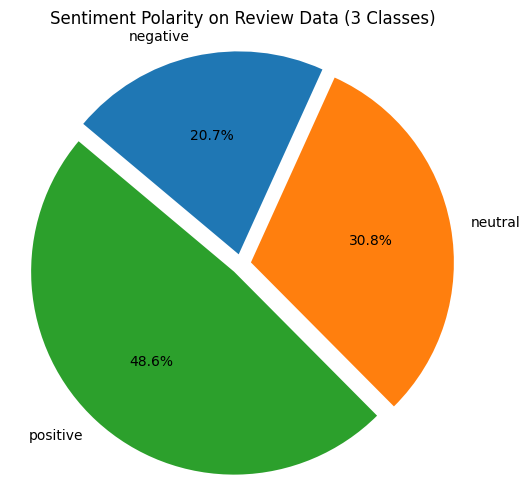

In [14]:
# Hitung jumlah tiap label polarity
label_counts = clean_df['polarity'].value_counts()
labels = label_counts.index
sizes = label_counts.values

# Tambahkan warna untuk 3 kelas
colors = ['#2ca02c', '#ff7f0e', '#1f77b4']  # green, orange, blue

# Tambahkan efek meledak untuk tiap segmen agar visual menarik
explode = [0.05] * len(labels)

# Buat pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.title('Sentiment Polarity on Review Data (3 Classes)')
plt.axis('equal')  # Biar lingkaran simetris
plt.show()

# EKSPLORASI LABEL

In [15]:
# Gabungkan semua teks berdasarkan label
positive_text = ' '.join(clean_df[clean_df['polarity'] == 'positive']['text_akhir'])
negative_text = ' '.join(clean_df[clean_df['polarity'] == 'negative']['text_akhir'])
neutral_text = ' '.join(clean_df[clean_df['polarity'] == 'neutral']['text_akhir'])

# Buat WordCloud untuk setiap label
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white', colormap='gray').generate(neutral_text)

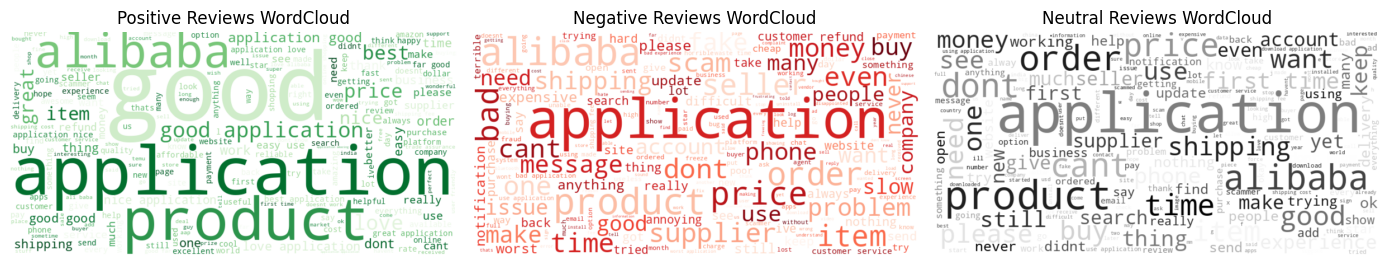

In [16]:
# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews WordCloud')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews WordCloud')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews WordCloud')
plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
1,69f9cd05-17e7-4459-92dd-b915fe959e0f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The app doesn't work properly. Firstly it tell...,2,1985,8.77.0,2025-01-25 21:37:16,We are sorry for your experience. If you have ...,2025-02-06 02:20:34,8.77.0,The app doesnt work properly Firstly it tells ...,the app doesnt work properly firstly it tells ...,the application doesnt work properly firstly i...,"[the, application, doesnt, work, properly, fir...","[application, doesnt, work, properly, firstly,...",application doesnt work properly firstly tells...,1.0,positive
2,1d6cb16d-c070-4db3-8dc9-8bb7ba86cb37,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The apps functionality seriously sucks.... Sea...,1,3539,8.71.1,2024-12-02 13:06:25,We are sorry for your experience. If you have ...,2024-12-03 01:23:10,8.71.1,The apps functionality seriously sucks Searchi...,the apps functionality seriously sucks searchi...,the apps functionality seriously sucks searchi...,"[the, apps, functionality, seriously, sucks, s...","[apps, functionality, seriously, sucks, search...",apps functionality seriously sucks searching i...,-1.0,negative
4,ef5a3285-4849-4fe8-8855-e8315f07ebd9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"The items are great, but when I click on one o...",2,15608,8.28.0,2023-10-23 05:10:01,"Hi, we are sorry to hear that. Do share additi...",2023-11-10 11:05:44,8.28.0,The items are great but when I click on one of...,the items are great but when i click on one of...,the items are great but when i click on one of...,"[the, items, are, great, but, when, i, click, ...","[items, great, click, one, variation, options,...",items great click one variation options add en...,3.0,positive
6,7a65dce8-3f09-4e4e-a263-55efebc13c65,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It's all around a great app except for the fac...,4,4342,6.10.2,2018-12-21 18:25:23,Thanks for your feedback. Could you tell us mo...,2018-01-10 06:01:58,6.10.2,Its all around a great app except for the face...,its all around a great app except for the face...,its all around a great application except for ...,"[its, all, around, a, great, application, exce...","[around, great, application, except, face, sen...",around great application except face send file...,4.0,positive
14,b3984ad2-24e5-4a6a-9f50-08c93a4bc7b6,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I concur that this app manipulates the audio d...,1,822,7.44.0,2021-11-19 03:42:39,The problem you reported has been fixed. Pleas...,2021-11-29 06:32:48,7.44.0,I concur that this app manipulates the audio d...,i concur that this app manipulates the audio d...,i concur that this application manipulates the...,"[i, concur, that, this, application, manipulat...","[concur, application, manipulates, audio, driv...",concur application manipulates audio driver st...,1.0,positive


# DATA SPLITTING DAN EKSTRASI FITUR

In [18]:
# Custom Callback untuk Early Stopping Target Akurasi 92%
class TargetAccuracyCallback(Callback):
    def __init__(self, target=0.92):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target:
            print(f"\n✅ Target val_accuracy {self.target} tercapai di epoch {epoch+1}. Stop training.")
            self.model.stop_training = True

# Label encoding untuk semua skema
le = LabelEncoder()
y_encoded = le.fit_transform(clean_df['polarity'])

# ------------------------------
# Skema 1: TF-IDF + Deep Neural Network (DNN) + 80/20
# ------------------------------
tfidf_1 = TfidfVectorizer(max_features=3000)
X_tfidf_1 = tfidf_1.fit_transform(clean_df['text_akhir']).toarray()

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_tfidf_1, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ------------------------------
# Skema 2: CountVectorizer + Deep Neural Network (DNN) + 80/20
# ------------------------------
cv_2 = CountVectorizer(max_features=3000)
X_cv_2 = cv_2.fit_transform(clean_df['text_akhir']).toarray()

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_cv_2, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


# ------------------------------
# Skema 3: Tokenization + Recurrent Neural Network (RNN) + 70/30
# ------------------------------
# Tokenisasi dan padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(clean_df['text_akhir'])

X_seq = tokenizer.texts_to_sequences(clean_df['text_akhir'])
X_pad = pad_sequences(X_seq, maxlen=100, padding='post', truncating='post')

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X_pad, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# MODELING

## Menggunakan Algoritma Deep Learning

In [21]:
model1 = Sequential()
model1.add(Dense(512, activation='relu', input_dim=X_train1.shape[1]))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(3, activation='softmax'))  # Jumlah kelas

model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history1 = model1.fit(
    X_train1, y_train1,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[TargetAccuracyCallback(target=0.92)],
    verbose=1
)

loss1, acc1 = model1.evaluate(X_test1, y_test1)
print("✅ SKEMA 1 (TF-IDF + DNN + 80/20) - Akurasi Test:", acc1)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4971 - loss: 0.9787 - val_accuracy: 0.7361 - val_loss: 0.5724
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8356 - loss: 0.4367 - val_accuracy: 0.8330 - val_loss: 0.3754
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9499 - loss: 0.1711 - val_accuracy: 0.8618 - val_loss: 0.3743
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9802 - loss: 0.0821 - val_accuracy: 0.8564 - val_loss: 0.4289
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9907 - loss: 0.0427 - val_accuracy: 0.8438 - val_loss: 0.5009
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9939 - loss: 0.0282 - val_accuracy: 0.8402 - val_loss: 0.4960
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9963 - loss: 0.0196 - val_accuracy: 0.8402 - val_loss: 0.5147
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9963 - loss: 0.0194 - val_accuracy: 0.

In [22]:
model2 = Sequential()
model2.add(Dense(512, activation='relu', input_dim=X_train2.shape[1]))
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit(
    X_train2, y_train2,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[TargetAccuracyCallback(target=0.92)],
    verbose=1
)

loss2, acc2 = model2.evaluate(X_test2, y_test2)
print("✅ SKEMA 2 (CountVectorizer + DNN + 80/20) - Akurasi Test:", acc2)


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5042 - loss: 0.9619 - val_accuracy: 0.8025 - val_loss: 0.5300
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8549 - loss: 0.4057 - val_accuracy: 0.8636 - val_loss: 0.4232
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9460 - loss: 0.1815 - val_accuracy: 0.8618 - val_loss: 0.4354
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9725 - loss: 0.1005 - val_accuracy: 0.8582 - val_loss: 0.4652
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9865 - loss: 0.0540 - val_accuracy: 0.8671 - val_loss: 0.5533
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9909 - loss: 0.0357 - val_accuracy: 0.8654 - val_loss: 0.5919
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9906 - loss: 0.0394 - val_accuracy: 0.8671 - val_loss: 0.6246
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9954 - loss: 0.0239 - val_accuracy: 0.

In [29]:
vocab_size = 5000
embedding_dim = 64
max_len = 100

model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model3.add(Bidirectional(LSTM(64)))
model3.add(Dropout(0.5))
model3.add(Dense(3, activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history3 = model3.fit(
    X_train3, y_train3,
    validation_split=0.1,
    epochs=25,
    batch_size=64,
    callbacks=[TargetAccuracyCallback(target=0.92)],
    verbose=1
)

loss3, acc3 = model3.evaluate(X_test3, y_test3)
print("✅ SKEMA 3 (Tokenizer + RNN-LSTM + 70/30) - Akurasi Test:", acc3)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.4967 - loss: 1.0118 - val_accuracy: 0.6516 - val_loss: 0.7704
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.7194 - loss: 0.6774 - val_accuracy: 0.7643 - val_loss: 0.5509
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.8403 - loss: 0.4308 - val_accuracy: 0.8381 - val_loss: 0.4553
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.9167 - loss: 0.2614 - val_accuracy: 0.8525 - val_loss: 0.4021
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9463 - loss: 0.1669 - val_accuracy: 0.8545 - val_loss: 0.4426
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.9699 - loss: 0.1164 - val_accuracy: 0.8730 - val_loss: 0.4172
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.9758 - loss: 0.0864 - val_accuracy: 0.8750 - val_loss: 0.4640
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9849 - loss: 0.0612 - val_accuracy: 0.860

## Visualisasi dan Report

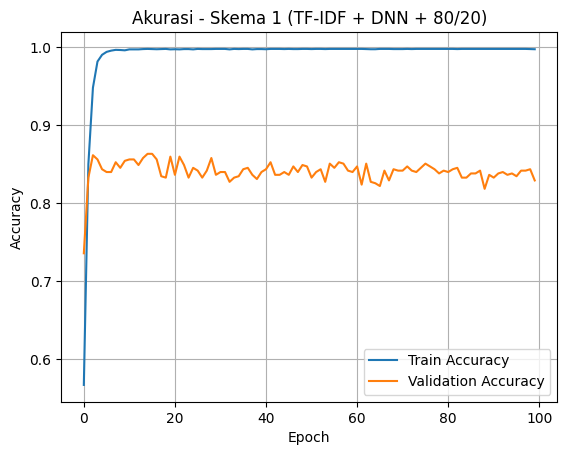

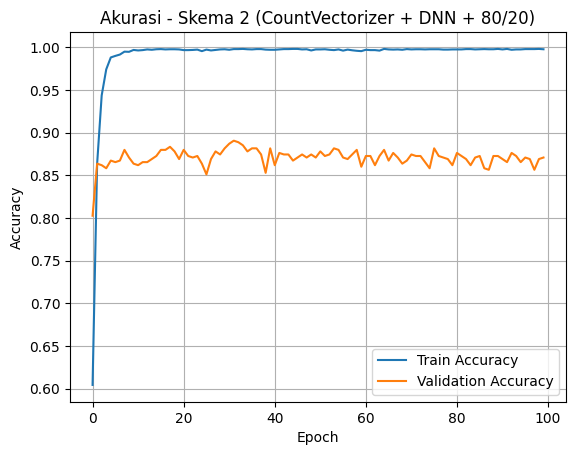

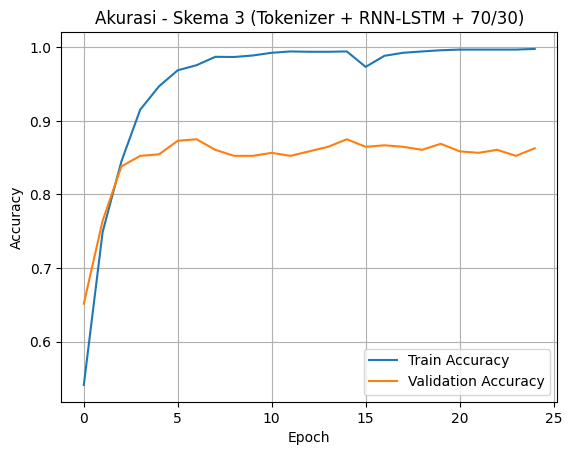

In [30]:
def plot_accuracy(history, skema_name):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Akurasi - {skema_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualisasi untuk tiap skema
plot_accuracy(history1, "Skema 1 (TF-IDF + DNN + 80/20)")
plot_accuracy(history2, "Skema 2 (CountVectorizer + DNN + 80/20)")
plot_accuracy(history3, "Skema 3 (Tokenizer + RNN-LSTM + 70/30)")

In [31]:
import pandas as pd

# Ambil akurasi training terakhir dari history
acc_train1 = history1.history['accuracy'][-1]
acc_train2 = history2.history['accuracy'][-1]
acc_train3 = history3.history['accuracy'][-1]

# Ringkasan akurasi
report_df = pd.DataFrame({
    "Skema": [
        "Skema 1 (TF-IDF + DNN + 80/20)",
        "Skema 2 (CountVectorizer + DNN + 80/20)",
        "Skema 3 (Tokenizer + RNN-LSTM + 70/30)"
    ],
    "Akurasi Training": [acc_train1, acc_train2, acc_train3],
    "Akurasi Testing": [acc1, acc2, acc3]
})

print("\n📊 Ringkasan Akurasi Setiap Skema:")
print(report_df)



📊 Ringkasan Akurasi Setiap Skema:
                                     Skema  Akurasi Training  Akurasi Testing
0           Skema 1 (TF-IDF + DNN + 80/20)          0.997605         0.850682
1  Skema 2 (CountVectorizer + DNN + 80/20)          0.997605         0.863604
2   Skema 3 (Tokenizer + RNN-LSTM + 70/30)          0.997719         0.856391


# Inference atau Prediksi Teks Baru

In [32]:
# Label encoder dari pelatihan
label_dict = dict(zip(le.transform(le.classes_), le.classes_))  # Contoh: {0: 'negatif', 1: 'netral', 2: 'positif'}

# Fungsi prediksi untuk skema DNN
def predict_sentiment_dnn(text, vectorizer, model):
    vectorized_text = vectorizer.transform([text]).toarray()
    pred = model.predict(vectorized_text)
    class_idx = pred.argmax(axis=1)[0]
    return label_dict[class_idx]

# Fungsi prediksi untuk skema RNN
def predict_sentiment_rnn(text, tokenizer, model, maxlen):
    sequences = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    pred = model.predict(padded_seq, verbose=0)
    return label_dict[pred.argmax(axis=1)[0]]

In [33]:
# List teks uji coba
sample_texts = [
    "The Alibaba app is a game-changer for our wholesale business! Easy to navigate and connect with reliable suppliers.", # positive
    "Excellent sourcing platform. Found high-quality manufacturers with competitive MOQs and fast response times.", # positive
    "Frustrating experience. Many suppliers don't respond to inquiries, and the app crashes during negotiations.", # negative
    "Beware of fake listings! We got scammed by a fraudulent seller claiming to be a gold supplier.", # negative
    "Decent for product discovery, but the transaction process could be more streamlined. Average experience.", # neutral
    "The app works fine, but supplier verification needs improvement. Some good deals among many mediocre offers." # neutral
]

In [34]:
# Inference semua teks dengan semua skema
print("📢 Hasil Inference:\n")
for i, text in enumerate(sample_texts, 1):
    print(f"Teks #{i}: {text}")
    print("Skema 1 (TF-IDF + DNN):", predict_sentiment_dnn(text, tfidf_1, model1))
    print("Skema 2 (CountVectorizer + DNN):", predict_sentiment_dnn(text, cv_2, model2))
    print("Skema 3 (Tokenizer + RNN-LSTM):", predict_sentiment_rnn(text, tokenizer, model3, max_len))
    print("-" * 90)

📢 Hasil Inference:

Teks #1: The Alibaba app is a game-changer for our wholesale business! Easy to navigate and connect with reliable suppliers.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Skema 1 (TF-IDF + DNN): positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Skema 2 (CountVectorizer + DNN): positive
Skema 3 (Tokenizer + RNN-LSTM): positive
------------------------------------------------------------------------------------------
Teks #2: Excellent sourcing platform. Found high-quality manufacturers with competitive MOQs and fast response times.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Skema 1 (TF-IDF + DNN): positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Skema 2 (CountVectorizer + DNN): positive
Skema 3 (Tokenizer + RNN-LSTM): positive
------------------------------------------------------------------------------------------
Teks #3: Frustrating experience. Many suppliers don't respond to inquiries, and the app crashes during negotiations.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Skema 1 (TF-IDF 

# Kesimpulan Hasil Inference Sentimen
Melakukan *inference* terhadap 6 contoh teks sentimen (positif, negatif, dan netral) menggunakan tiga skema deep learning berbeda:

- **Skema 1**: TF-IDF + DNN  
- **Skema 2**: CountVectorizer + DNN  
- **Skema 3**: Tokenizer + RNN-LSTM  

---

## 📊 Ringkasan Hasil Klasifikasi

| No | Teks | Label Seharusnya | Skema 1 | Skema 2 | Skema 3 |
|----|------|------------------|---------|---------|---------|
| 1  | sample_text1 |   Positif  | ✅ Positif | ✅ Positif | ✅ Positif |
| 2  | sample_text2 |   Positif  | ✅ Positif | ✅ Positif | ✅ Positif |
| 3  | sample_text3 |   Negatif  | ✅ Negatif | ✅ Negatif | ✅ Negatif |
| 4  | sample_text4 |   Negatif  | ✅ Negatif | ✅ Negatif | ✅ Negatif |
| 5  | sample_text5 |   Netral   | ✅ Netral  | ✅ Netral  | ✅ Netral  |
| 6  | sample_text6 |   Netral   | ❌ Positif | ❌ Positif | ❌ Positif |

---

## Analisis

1. **Akurasi inference sangat baik**, karena 5 dari 6 teks berhasil diklasifikasikan sesuai label yang diharapkan oleh semua skema.
2. **Kesalahan hanya terjadi pada Teks #6**, yang seharusnya netral namun diklasifikasikan sebagai *positif* oleh seluruh model.  
   Kemungkinan karena frasa positif seperti:
   > _"Some good deals..."_ dan _"The app works fine..."_  
   menyebabkan tone kalimat lebih condong ke arah positif.
3. Menunjukkan bahwa **nuansa sentimen campuran** (pujian + kritik ringan) masih menjadi tantangan bagi model dalam membedakan *netral* vs *positif*.
4. Konsistensi hasil dari ketiga skema memperlihatkan bahwa model sudah memahami pola sentimen dengan cukup baik, meski masih ada keterbatasan dalam area *ambiguous*.

---

## Rekomendasi

- Tambahkan lebih banyak **contoh kalimat netral** saat pelatihan agar model tidak mudah bias ke positif/negatif.
- Gunakan **fitur lanjutan** seperti analisis negasi, konjungsi, dan pembobotan kata-kata sentimen untuk meningkatkan akurasi pada kalimat ambigu.
- Eksplorasi model lebih kompleks seperti **attention-based RNN** atau **transformer architecture** (misalnya BERT) untuk hasil yang lebih presisi.

---
